In [1]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2023-07-17 08:10:03.375754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

2.12.0


In [12]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [13]:
model_tree_type=1# 1= xgboost  2=random forest
option_cate_feature=1

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

In [14]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [15]:
metric="accuracy"
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model='multi_xgb_tf_model'
    else:
         _model='multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model='binary_xgb_tf_model'
    else:
         _model='binary_rf_tf_model'

model_gs_path=f"gs://demo-tuned-tf-incident-pongthorn/{_model}"
print(model_gs_path)
#model_local_path=_model

gs://demo-tuned-tf-incident-pongthorn/binary_xgb_tf_model


In [16]:
if option_cate_feature==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'range_open_to_close_hour']
NumbericCols : []
UnusedCols : ['id', 'severity_id', 'severity_name', 'open_to_close_hour', 'label_multi_severity']


# Load & Prepare Data

In [17]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [18]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_binary_severity     2241 non-null   int64 
 1   sla                       2241 non-null   object
 2   product_type              2241 non-null   object
 3   brand                     2241 non-null   object
 4   service_type              2241 non-null   object
 5   incident_type             2241 non-null   object
 6   range_open_to_close_hour  2241 non-null   object
dtypes: int64(1), object(6)
memory usage: 122.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_binary_severity     561 non-null    int64 
 1   sla                       561 non-null    object
 2   product_type              

In [19]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1]

In [20]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
2236,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,soonest
2237,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,latest
2238,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,soonest
2239,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,fair
2240,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soonest


In [21]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
556,0,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Request,Software,late
557,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,soonest
558,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,late
559,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon
560,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon


# Build Model

In [22]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

In [23]:
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    model=tfdf.keras.GradientBoostedTreesModel()
else:
    print("RandomForestModel")
    model = tfdf.keras.RandomForestModel()

model.fit(x=train_ds)

GradientBoostedTreesModel
Use /var/tmp/tmprlyzaukz as temporary training directory
Reading training dataset...


[WARNING 23-07-17 08:12:43.8011 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-17 08:12:43.8021 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-17 08:12:43.8029 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-17 08:12:43.861480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2241]
	 [[{{node Placeholder/_0}}]]


Training dataset read in 0:00:04.159671. Found 2241 examples.
Training model...
Model trained in 0:00:00.191245
Compiling model...


[INFO 23-07-17 08:12:48.1711 UTC kernel.cc:1243] Loading model from path /var/tmp/tmprlyzaukz/model/ with prefix b37505adb41b41e1
[INFO 23-07-17 08:12:48.1858 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-17 08:12:48.1865 UTC kernel.cc:1075] Use fast generic engine
2023-07-17 08:12:48.217644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2241]
	 [[{{node Placeholder/_2}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [24]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2023-07-17 08:12:50.554496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [561]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 366ms/step - loss: 0.0000e+00 - accuracy: 0.7843
loss: 0.0000
accuracy: 0.7843


# Inspect and debug decision forest models
## Model structure and feature importance

In [26]:

inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

#[field for field in dir(inspector) if not field.startswith("_")]
# SUM_SCORE ,NUM_AS_ROOT

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 58
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "product_type" (4; #3), "range_open_to_close_hour" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


In [27]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 SUM_SCORE
	 NUM_AS_ROOT


# Model Self Evaluation

In [28]:
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.8082901835441589, loss=0.7658236622810364, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

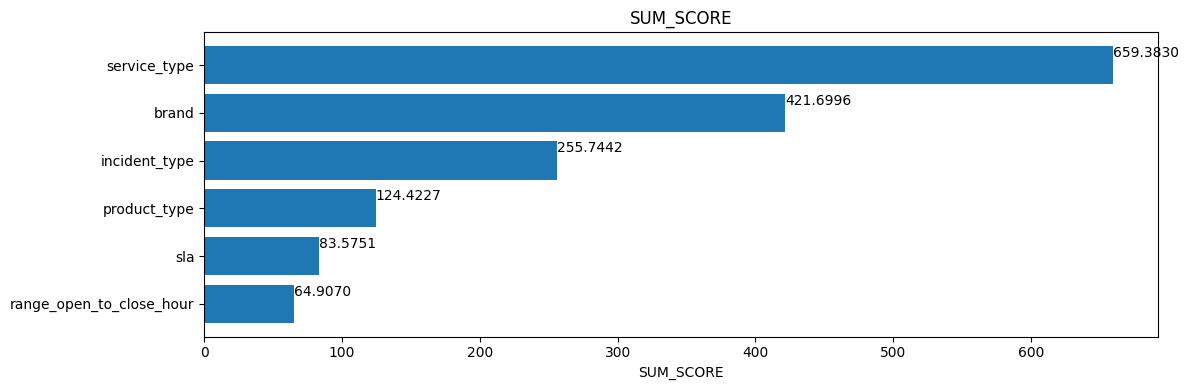

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()

# Plot the model

In [30]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Plotting the training logs

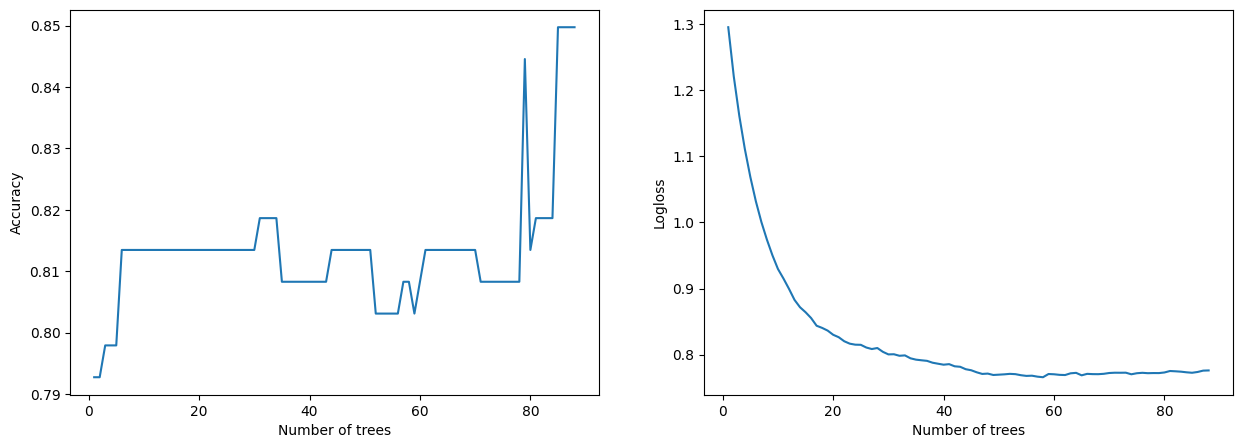

In [31]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

# Save Model

In [32]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/binary_xgb_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/binary_xgb_tf_model/assets
